# Feature Engeneering first tests

In [1]:
# --- Bibliotecas para Manipulação e Modelagem ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Bibliotecas para Visualização ---
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configurações de Estilo ---
plt.style.use('seaborn-v0_8-whitegrid')
print("Bibliotecas importadas com sucesso.")

# --- Carregamento dos Dados ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

print("DataFrame carregado com sucesso.")

Bibliotecas importadas com sucesso.
DataFrame carregado com sucesso.


In [2]:
def create_features(df, target_variable='ph'):
    """
    Cria features de séries temporais a partir de um dataframe com DatetimeIndex.
    """
    df_features = df.copy()
    
    # Lags da variável alvo
    # Usaremos lags que cobrem as últimas 24 horas
    lags = [1, 2, 3, 6, 9, 12, 24, 48, 72] # De 20min a 24h atrás
    for lag in lags:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
        
    # Features de Janela Deslizante (Rolling Window)
    # Média e Desvio Padrão das últimas 12h e 24h
    window_sizes = [36, 72] # 12 horas e 24 horas
    for window in window_sizes:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()

    return df_features

print("Função 'create_features' definida.")

Função 'create_features' definida.


In [3]:
# Aplica a função de engenharia de features no nosso dataframe
df_featured = create_features(df, target_variable='ph')

# Remove as linhas com valores NaN geradas pelos lags e janelas
df_featured = df_featured.dropna()

print("Features criadas com sucesso. Visualizando as novas colunas:")
# O 'display' mostra a tabela de forma mais bonita no Jupyter
display(df_featured.head())

print("\nDimensões do novo DataFrame:", df_featured.shape)

Features criadas com sucesso. Visualizando as novas colunas:


,ph,od,ta,te,um,orp,ec,tds,hora,radiacao,...,ph_lag_6,ph_lag_9,ph_lag_12,ph_lag_24,ph_lag_48,ph_lag_72,ph_rolling_mean_36,ph_rolling_std_36,ph_rolling_mean_72,ph_rolling_std_72
2020-07-18 00:00:00,9.180,6.74,22.44,20.20,48.8,516.32,84.84,46.0,0,0.0,...,9.275,9.310,9.330,8.87,9.080,9.240,9.023333,0.367027,9.041042,0.285419
2020-07-18 00:20:00,9.190,6.32,22.41,20.10,49.0,513.38,84.46,46.0,0,0.0,...,9.250,9.290,9.320,8.97,9.050,9.240,9.044167,0.354025,9.040347,0.284989
2020-07-18 00:40:00,9.150,6.59,22.39,20.10,49.2,510.88,84.89,46.0,0,0.0,...,9.240,9.290,9.315,9.09,9.070,9.240,9.063056,0.340393,9.039097,0.284297
2020-07-18 01:00:00,9.160,6.50,22.36,20.00,49.2,509.10,84.15,45.0,1,0.0,...,9.220,9.275,9.310,9.24,9.050,9.210,9.083611,0.322314,9.038403,0.283935
2020-07-18 01:20:00,9.145,6.33,22.32,19.95,49.7,506.79,83.65,45.0,1,0.0,...,9.230,9.250,9.290,9.28,8.995,9.195,9.105139,0.298275,9.037708,0.283607



Dimensões do novo DataFrame: (5040, 32)


In [4]:
# --- Divisão dos Dados em Treino e Teste ---
# Usamos o mesmo tamanho de teste para uma comparação justa
test_size = 7 * 24 * 3 
train_featured = df_featured[:-test_size]
test_featured = df_featured[-test_size:]

# Separar as features (X) da variável alvo (y)
FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'

X_train = train_featured[FEATURES]
y_train = train_featured[TARGET]

X_test = test_featured[FEATURES]
y_test = test_featured[TARGET]

print("Dados divididos em treino e teste com as novas features.")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")

Dados divididos em treino e teste com as novas features.
Formato de X_train: (4536, 31)
Formato de X_test: (504, 31)


Iniciando o treinamento do modelo LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6409
[LightGBM] [Info] Number of data points in the train set: 4536, number of used features: 31
[LightGBM] [Info] Start training from score 8.780000
Treinamento concluído.

--- Resultados do Modelo LightGBM ---
MAE (Mean Absolute Error): 0.0592
RMSE (Root Mean Squared Error): 0.0825


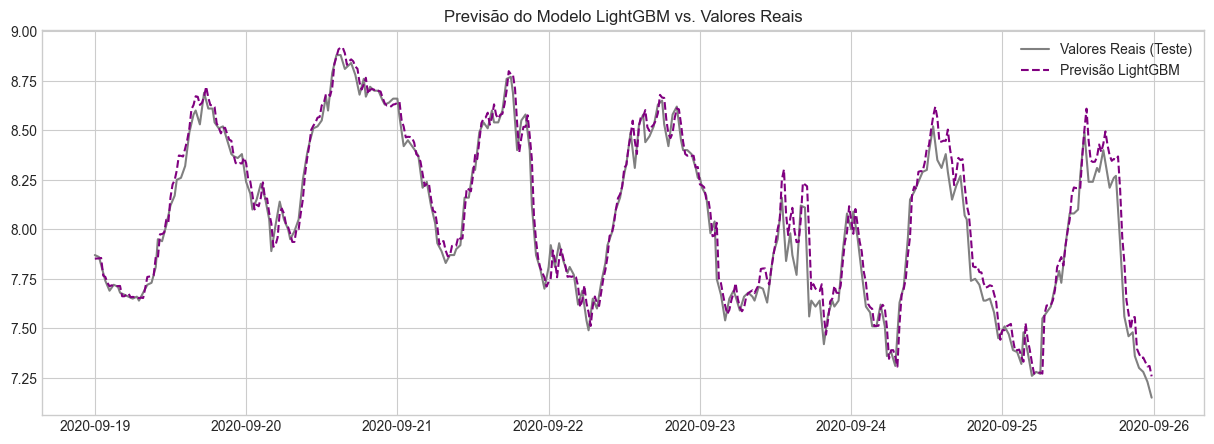

In [5]:
# --- Treinamento do Modelo LightGBM ---
print("Iniciando o treinamento do modelo LightGBM...")

# Inicializamos o modelo com alguns parâmetros padrão
lgb_model = lgb.LGBMRegressor(
    objective='mae', # Otimizar diretamente para o Mean Absolute Error
    n_estimators=1000, # Número de árvores
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1, # Usar todos os processadores
    seed=42
)

# Treinar o modelo
lgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(100, verbose=False)]) # Parar cedo se não houver melhora

print("Treinamento concluído.")

# --- Previsão e Avaliação ---
lgb_forecast = lgb_model.predict(X_test)

# Calcular as métricas de erro
mae_lgb = mean_absolute_error(y_test, lgb_forecast)
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_forecast))

print("\n--- Resultados do Modelo LightGBM ---")
print(f"MAE (Mean Absolute Error): {mae_lgb:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_lgb:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, lgb_forecast, label='Previsão LightGBM', color='purple', linestyle='--')
ax.set_title('Previsão do Modelo LightGBM vs. Valores Reais')
ax.legend()
plt.show()

Iniciando o treinamento do modelo Random Forest...
Treinamento concluído em 1.61 segundos.

--- Resultados do Modelo Random Forest ---
MAE (Mean Absolute Error): 0.0609
RMSE (Root Mean Squared Error): 0.0885


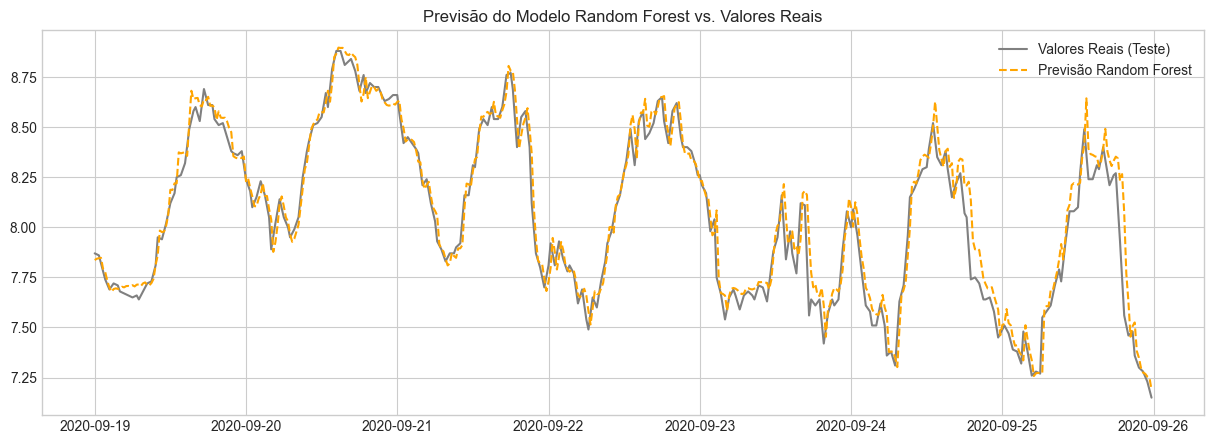

In [7]:
# --- Bibliotecas Adicionais ---
from sklearn.ensemble import RandomForestRegressor
import time

# --- Assumimos que X_train, y_train, X_test, y_test já existem ---

# --- Treinamento do Modelo Random Forest ---
print("Iniciando o treinamento do modelo Random Forest...")
start_time = time.time()

# Inicializamos o modelo
# n_estimators é o número de árvores na floresta
# n_jobs=-1 usa todos os processadores para acelerar
rf_model = RandomForestRegressor(
    n_estimators=100, 
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo
rf_model.fit(X_train, y_train)

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- Previsão e Avaliação ---
rf_forecast = rf_model.predict(X_test)

# Calcular as métricas de erro
mae_rf = mean_absolute_error(y_test, rf_forecast)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_forecast))

print("\n--- Resultados do Modelo Random Forest ---")
print(f"MAE (Mean Absolute Error): {mae_rf:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_rf:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, rf_forecast, label='Previsão Random Forest', color='orange', linestyle='--')
ax.set_title('Previsão do Modelo Random Forest vs. Valores Reais')
ax.legend()
plt.show()

Iniciando o treinamento do modelo Decision Tree...
Treinamento concluído em 0.15 segundos.

--- Resultados do Modelo Decision Tree ---
MAE (Mean Absolute Error): 0.1162
RMSE (Root Mean Squared Error): 0.2853


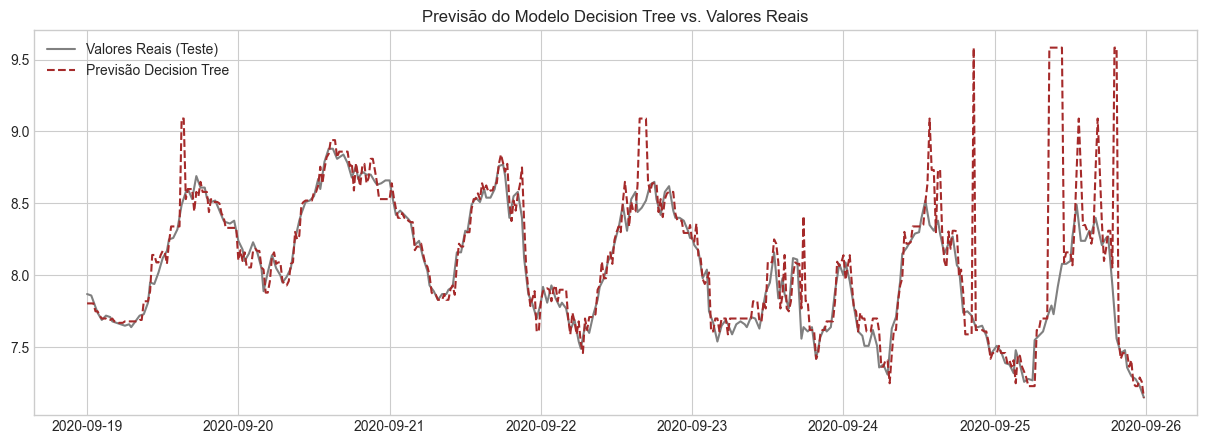

In [8]:
# --- Bibliotecas Adicionais ---
from sklearn.tree import DecisionTreeRegressor
import time

# --- Assumimos que X_train, y_train, X_test, y_test já existem ---

# --- Treinamento do Modelo Decision Tree ---
print("Iniciando o treinamento do modelo Decision Tree...")
start_time = time.time()

# Inicializamos o modelo
dt_model = DecisionTreeRegressor(random_state=42)

# Treinar o modelo
dt_model.fit(X_train, y_train)

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- Previsão e Avaliação ---
dt_forecast = dt_model.predict(X_test)

# Calcular as métricas de erro
mae_dt = mean_absolute_error(y_test, dt_forecast)
rmse_dt = np.sqrt(mean_squared_error(y_test, dt_forecast))

print("\n--- Resultados do Modelo Decision Tree ---")
print(f"MAE (Mean Absolute Error): {mae_dt:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_dt:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, dt_forecast, label='Previsão Decision Tree', color='brown', linestyle='--')
ax.set_title('Previsão do Modelo Decision Tree vs. Valores Reais')
ax.legend()
plt.show()

Iniciando o treinamento do modelo XGBoost...
Treinamento concluído em 0.53 segundos.

--- Resultados do Modelo XGBoost ---
MAE (Mean Absolute Error): 0.1045
RMSE (Root Mean Squared Error): 0.1660


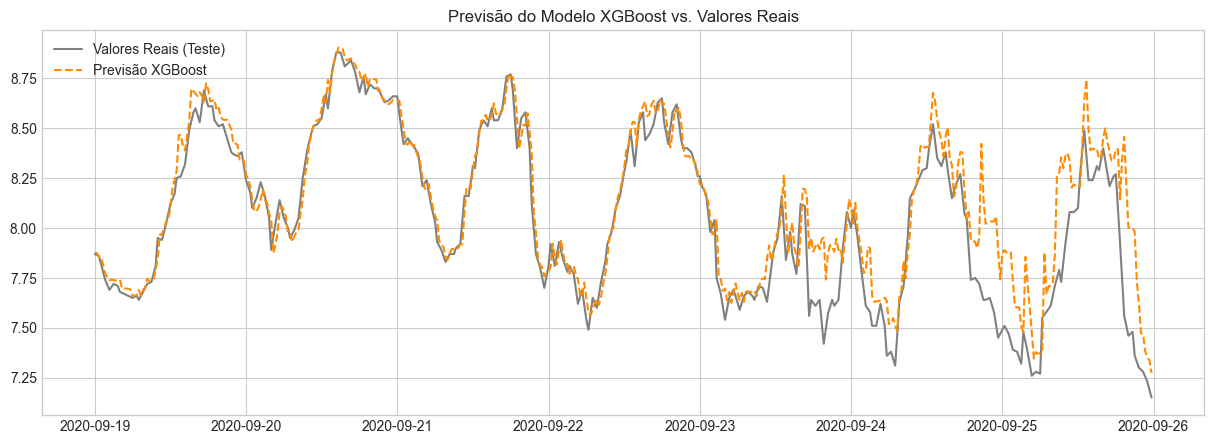

In [9]:
# --- Bibliotecas Adicionais ---
import xgboost as xgb
import time

# --- Assumimos que X_train, y_train, X_test, y_test já existem ---

# --- Treinamento do Modelo XGBoost ---
print("Iniciando o treinamento do modelo XGBoost...")
start_time = time.time()

# Inicializamos o modelo
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Objetivo padrão para regressão
    n_estimators=1000,
    learning_rate=0.05,
    n_jobs=-1,
    seed=42,
    early_stopping_rounds=100 # Equivalente ao early_stopping do LightGBM
)

# Treinar o modelo
# O XGBoost precisa que o eval_set seja passado dentro do .fit()
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False) # verbose=False para não imprimir o log de cada árvore

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- Previsão e Avaliação ---
xgb_forecast = xgb_model.predict(X_test)

# Calcular as métricas de erro
mae_xgb = mean_absolute_error(y_test, xgb_forecast)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_forecast))

print("\n--- Resultados do Modelo XGBoost ---")
print(f"MAE (Mean Absolute Error): {mae_xgb:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_xgb:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, xgb_forecast, label='Previsão XGBoost', color='darkorange', linestyle='--')
ax.set_title('Previsão do Modelo XGBoost vs. Valores Reais')
ax.legend()
plt.show()

In [20]:
import seaborn as sns 
from pathlib import Path

# --- Configuração de Caminhos (Versão Corrigida e Robusta) ---

# Define o caminho base
# O 'r' aqui não causa problema porque não termina com '\'
base_path = Path(r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY')

# Usa o operador '/' do pathlib para juntar os caminhos de forma segura
# Isso funciona em qualquer sistema operacional (Windows, Linux, etc.)
output_dir_tables = base_path / 'tables'

# Cria o diretório, se ele não existir
output_dir_tables.mkdir(parents=True, exist_ok=True)

print(f"Diretório para salvar tabelas configurado com sucesso: {output_dir_tables}")# --- Célula Final: Tabela Comparativa Consolidada ---

# 1. Carregar os resultados dos modelos de baseline do notebook anterior
try:
    path_baseline_results = output_dir_tables / 'table02_baseline_model_comparison.csv'
    baseline_df = pd.read_csv(path_baseline_results)
except FileNotFoundError:
    print("Arquivo de resultados do baseline não encontrado. Criando um DataFrame vazio.")
    baseline_df = pd.DataFrame(columns=['Model', 'MAE', 'RMSE'])


# 2. Criar um DataFrame com os resultados dos modelos de ML deste notebook
ml_results_data = {
    'Model': [
        'LightGBM', 
        'Random Forest',
        'Decision Tree',
        'XGBoost'
    ],
    'MAE': [
        mae_lgb, 
        mae_rf,
        mae_dt,
        mae_xgb
    ],
    'RMSE': [
        rmse_lgb, 
        rmse_rf,
        rmse_dt,
        rmse_xgb
    ]
}
ml_df = pd.DataFrame(ml_results_data)

# 3. Concatenar os dois DataFrames para criar a tabela final
final_results_df = pd.concat([baseline_df, ml_df], ignore_index=True)


# 4. Ordenar o DataFrame final pelo MAE
final_results_df = final_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

# 5. Configurar o caminho de saída para a nova tabela
output_path_table_ml = output_dir_tables / 'table03_ml_model_comparison.csv'

# 6. Salvar a tabela final em um arquivo CSV
final_results_df.to_csv(output_path_table_ml, index=False)

# 7. Exibir a tabela final no notebook
print("--- Tabela Comparativa Final (Baselines + ML) ---")
display(final_results_df)

print(f"\nTabela de resultados consolidada salva com sucesso em: {output_path_table_ml}")

Diretório para salvar tabelas configurado com sucesso: D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY\tables
--- Tabela Comparativa Final (Baselines + ML) ---


,Model,MAE,RMSE
0,LightGBM,0.059193,0.082505
1,Random Forest,0.060949,0.088512
2,XGBoost,0.104503,0.165989
3,Decision Tree,0.116176,0.285324
4,Seasonal Naive,0.301944,0.397377
5,"ARIMAX(8,1,0) Benchmark",0.334664,0.412999
6,Naive,0.375060,0.448137



Tabela de resultados consolidada salva com sucesso em: D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY\tables\table03_ml_model_comparison.csv


--- Análise de Importância das Features (LightGBM) ---
As 20 features mais importantes segundo o modelo LightGBM:


,index,feature,importance
0,18,ph_lag_1,1006
1,0,od,588
2,4,orp,546
3,2,te,463
4,1,ta,366
5,3,um,350
6,25,ph_lag_48,331
7,26,ph_lag_72,326
8,23,ph_lag_12,313
9,19,ph_lag_2,310


C:\Users\User\AppData\Local\Temp\ipykernel_292\2613231426.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), ax=ax, palette='viridis')


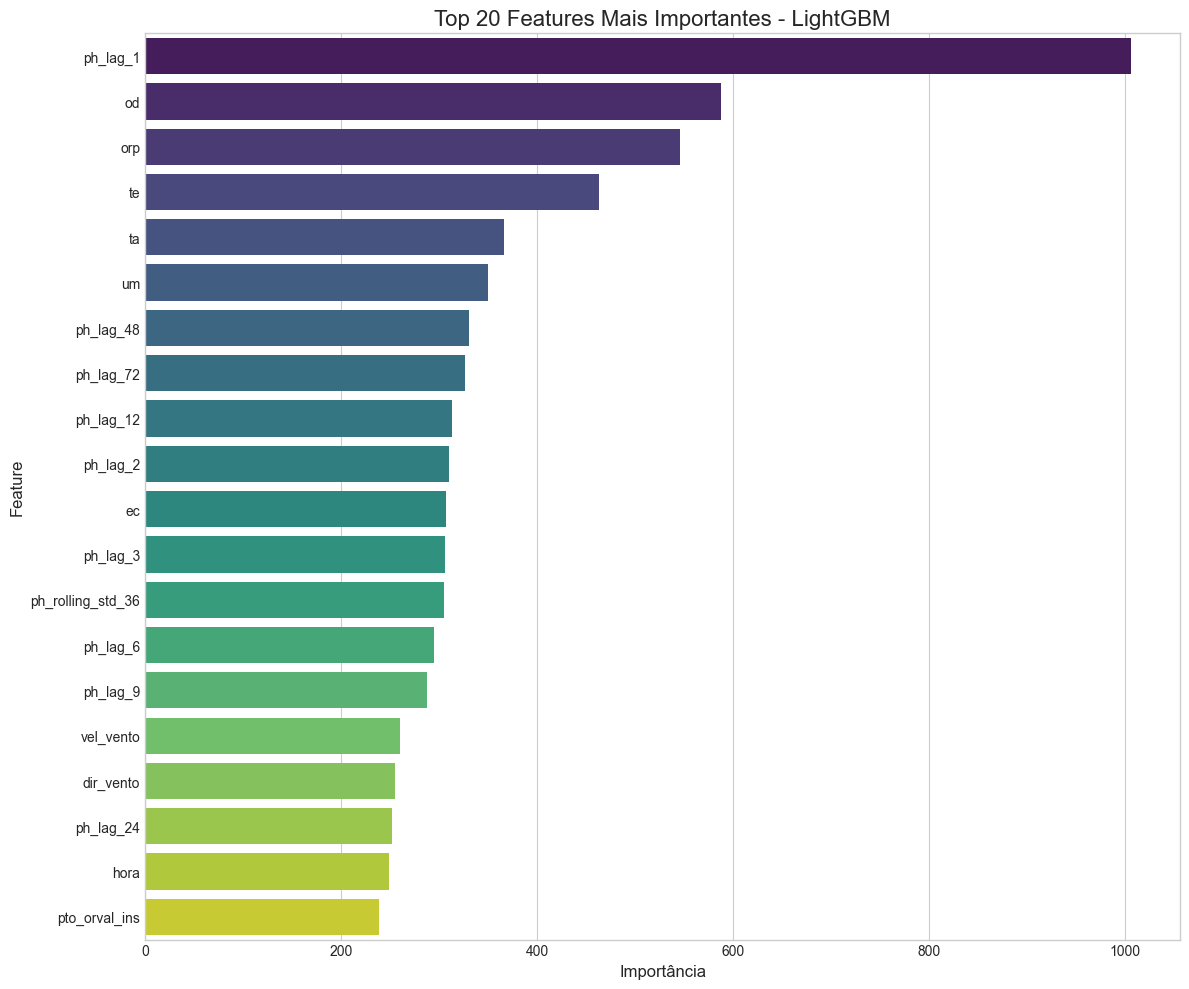

In [23]:
# --- Análise de Importância das Features ---
print("--- Análise de Importância das Features (LightGBM) ---")

# Criar um DataFrame com a importância de cada feature
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False).reset_index()

# Exibir as 20 features mais importantes
print("As 20 features mais importantes segundo o modelo LightGBM:")
display(feature_importance_df.head(40))

# --- Visualização da Importância das Features ---
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), ax=ax, palette='viridis')
ax.set_title('Top 20 Features Mais Importantes - LightGBM', fontsize=16)
ax.set_xlabel('Importância', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Feature Engeneering (lags 1,2,3,4,5,6,7,8,12,36,37,38,69,70,71,72)

In [24]:
# --- Bibliotecas para Manipulação e Modelagem ---
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Bibliotecas para Visualização ---
import matplotlib.pyplot as plt
from pathlib import Path

# --- Configurações de Estilo ---
plt.style.use('seaborn-v0_8-whitegrid')
print("Bibliotecas importadas com sucesso.")

# --- Carregamento dos Dados ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

print("DataFrame carregado com sucesso.")

Bibliotecas importadas com sucesso.
DataFrame carregado com sucesso.


In [25]:
def create_features(df, target_variable='ph'):
    """
    Cria features de séries temporais a partir de um dataframe com DatetimeIndex.
    """
    df_features = df.copy()
    
    # Lags da variável alvo
    # Usaremos lags que cobrem as últimas 24 horas
    lags = [1,2,3,4,5,6,7,8,9,12,36,37,38,69,70,71,72] # De 20min a 24h atrás
    for lag in lags:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
        
    # Features de Janela Deslizante (Rolling Window)
    # Média e Desvio Padrão das últimas 12h e 24h
    window_sizes = [12,36,72] # 12 horas e 24 horas
    for window in window_sizes:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()

    return df_features

print("Função 'create_features' definida.")

Função 'create_features' definida.


In [26]:
# Aplica a função de engenharia de features no nosso dataframe
df_featured = create_features(df, target_variable='ph')

# Remove as linhas com valores NaN geradas pelos lags e janelas
df_featured = df_featured.dropna()

print("Features criadas com sucesso. Visualizando as novas colunas:")
# O 'display' mostra a tabela de forma mais bonita no Jupyter
display(df_featured.head())

print("\nDimensões do novo DataFrame:", df_featured.shape)

Features criadas com sucesso. Visualizando as novas colunas:


,ph,od,ta,te,um,orp,ec,tds,hora,radiacao,...,ph_lag_69,ph_lag_70,ph_lag_71,ph_lag_72,ph_rolling_mean_12,ph_rolling_std_12,ph_rolling_mean_36,ph_rolling_std_36,ph_rolling_mean_72,ph_rolling_std_72
2020-07-18 00:00:00,9.180,6.74,22.44,20.20,48.8,516.32,84.84,46.0,0,0.0,...,9.210,9.240,9.240,9.240,9.260833,0.045768,9.023333,0.367027,9.041042,0.285419
2020-07-18 00:20:00,9.190,6.32,22.41,20.10,49.0,513.38,84.46,46.0,0,0.0,...,9.195,9.210,9.240,9.240,9.250000,0.045875,9.044167,0.354025,9.040347,0.284989
2020-07-18 00:40:00,9.150,6.59,22.39,20.10,49.2,510.88,84.89,46.0,0,0.0,...,9.200,9.195,9.210,9.240,9.236250,0.049227,9.063056,0.340393,9.039097,0.284297
2020-07-18 01:00:00,9.160,6.50,22.36,20.00,49.2,509.10,84.15,45.0,1,0.0,...,9.200,9.200,9.195,9.210,9.223750,0.047822,9.083611,0.322314,9.038403,0.283935
2020-07-18 01:20:00,9.145,6.33,22.32,19.95,49.7,506.79,83.65,45.0,1,0.0,...,9.210,9.200,9.200,9.195,9.211667,0.047879,9.105139,0.298275,9.037708,0.283607



Dimensões do novo DataFrame: (5040, 42)


In [27]:
# --- Divisão dos Dados em Treino e Teste ---
# Usamos o mesmo tamanho de teste para uma comparação justa
test_size = 7 * 24 * 3 
train_featured = df_featured[:-test_size]
test_featured = df_featured[-test_size:]

# Separar as features (X) da variável alvo (y)
FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'

X_train = train_featured[FEATURES]
y_train = train_featured[TARGET]

X_test = test_featured[FEATURES]
y_test = test_featured[TARGET]

print("Dados divididos em treino e teste com as novas features.")
print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de X_test: {X_test.shape}")

Dados divididos em treino e teste com as novas features.
Formato de X_train: (4536, 41)
Formato de X_test: (504, 41)


Iniciando o treinamento do modelo LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8937
[LightGBM] [Info] Number of data points in the train set: 4536, number of used features: 41
[LightGBM] [Info] Start training from score 8.780000
Treinamento concluído.

--- Resultados do Modelo LightGBM ---
MAE (Mean Absolute Error): 0.0601
RMSE (Root Mean Squared Error): 0.0813


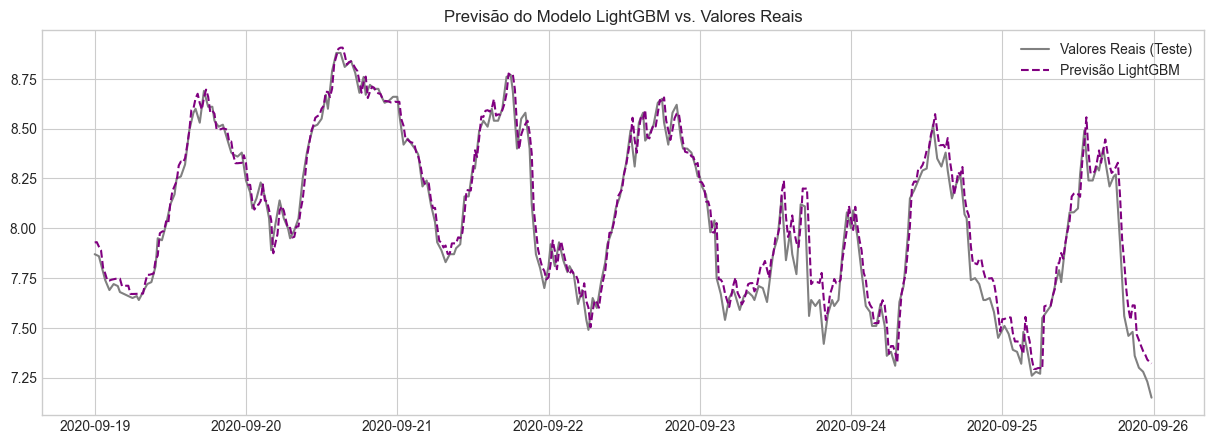

In [28]:
# --- Treinamento do Modelo LightGBM ---
print("Iniciando o treinamento do modelo LightGBM...")

# Inicializamos o modelo com alguns parâmetros padrão
lgb_model = lgb.LGBMRegressor(
    objective='mae', # Otimizar diretamente para o Mean Absolute Error
    n_estimators=1000, # Número de árvores
    learning_rate=0.05,
    num_leaves=31,
    n_jobs=-1, # Usar todos os processadores
    seed=42
)

# Treinar o modelo
lgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(100, verbose=False)]) # Parar cedo se não houver melhora

print("Treinamento concluído.")

# --- Previsão e Avaliação ---
lgb_forecast = lgb_model.predict(X_test)

# Calcular as métricas de erro
mae_lgb = mean_absolute_error(y_test, lgb_forecast)
rmse_lgb = np.sqrt(mean_squared_error(y_test, lgb_forecast))

print("\n--- Resultados do Modelo LightGBM ---")
print(f"MAE (Mean Absolute Error): {mae_lgb:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_lgb:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, lgb_forecast, label='Previsão LightGBM', color='purple', linestyle='--')
ax.set_title('Previsão do Modelo LightGBM vs. Valores Reais')
ax.legend()
plt.show()

Iniciando o treinamento do modelo Random Forest...
Treinamento concluído em 2.07 segundos.

--- Resultados do Modelo Random Forest ---
MAE (Mean Absolute Error): 0.0591
RMSE (Root Mean Squared Error): 0.0823


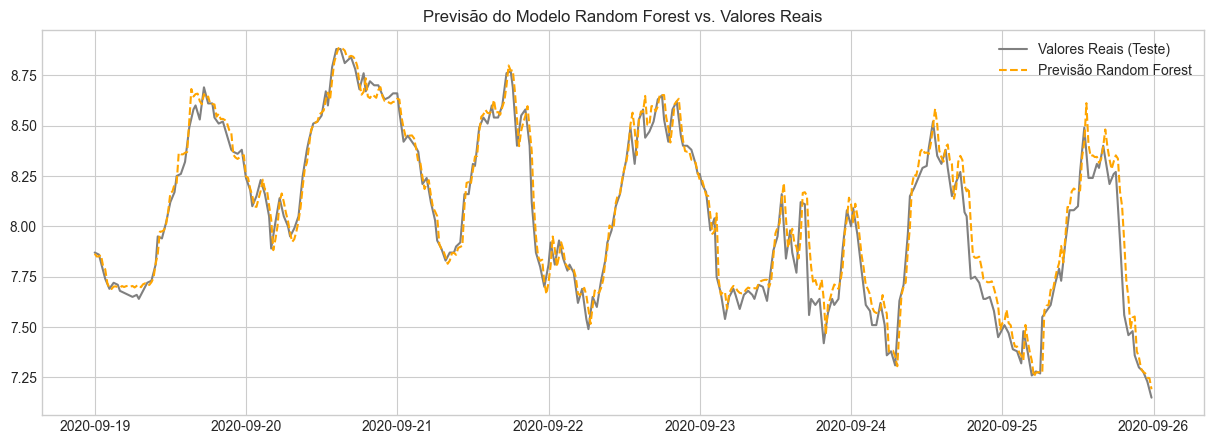

In [29]:
# --- Bibliotecas Adicionais ---
from sklearn.ensemble import RandomForestRegressor
import time

# --- Assumimos que X_train, y_train, X_test, y_test já existem ---

# --- Treinamento do Modelo Random Forest ---
print("Iniciando o treinamento do modelo Random Forest...")
start_time = time.time()

# Inicializamos o modelo
# n_estimators é o número de árvores na floresta
# n_jobs=-1 usa todos os processadores para acelerar
rf_model = RandomForestRegressor(
    n_estimators=100, 
    n_jobs=-1,
    random_state=42
)

# Treinar o modelo
rf_model.fit(X_train, y_train)

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- Previsão e Avaliação ---
rf_forecast = rf_model.predict(X_test)

# Calcular as métricas de erro
mae_rf = mean_absolute_error(y_test, rf_forecast)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_forecast))

print("\n--- Resultados do Modelo Random Forest ---")
print(f"MAE (Mean Absolute Error): {mae_rf:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_rf:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, rf_forecast, label='Previsão Random Forest', color='orange', linestyle='--')
ax.set_title('Previsão do Modelo Random Forest vs. Valores Reais')
ax.legend()
plt.show()

Iniciando o treinamento do modelo Decision Tree...
Treinamento concluído em 0.21 segundos.

--- Resultados do Modelo Decision Tree ---
MAE (Mean Absolute Error): 0.0966
RMSE (Root Mean Squared Error): 0.2594


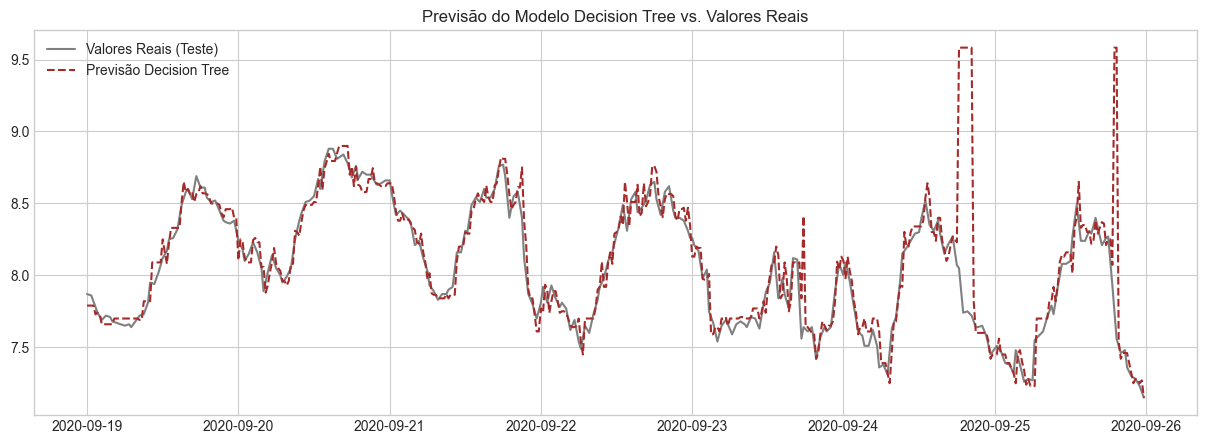

In [30]:
# --- Bibliotecas Adicionais ---
from sklearn.tree import DecisionTreeRegressor
import time

# --- Assumimos que X_train, y_train, X_test, y_test já existem ---

# --- Treinamento do Modelo Decision Tree ---
print("Iniciando o treinamento do modelo Decision Tree...")
start_time = time.time()

# Inicializamos o modelo
dt_model = DecisionTreeRegressor(random_state=42)

# Treinar o modelo
dt_model.fit(X_train, y_train)

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- Previsão e Avaliação ---
dt_forecast = dt_model.predict(X_test)

# Calcular as métricas de erro
mae_dt = mean_absolute_error(y_test, dt_forecast)
rmse_dt = np.sqrt(mean_squared_error(y_test, dt_forecast))

print("\n--- Resultados do Modelo Decision Tree ---")
print(f"MAE (Mean Absolute Error): {mae_dt:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_dt:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, dt_forecast, label='Previsão Decision Tree', color='brown', linestyle='--')
ax.set_title('Previsão do Modelo Decision Tree vs. Valores Reais')
ax.legend()
plt.show()

Iniciando o treinamento do modelo XGBoost...
Treinamento concluído em 0.89 segundos.

--- Resultados do Modelo XGBoost ---
MAE (Mean Absolute Error): 0.1057
RMSE (Root Mean Squared Error): 0.1677


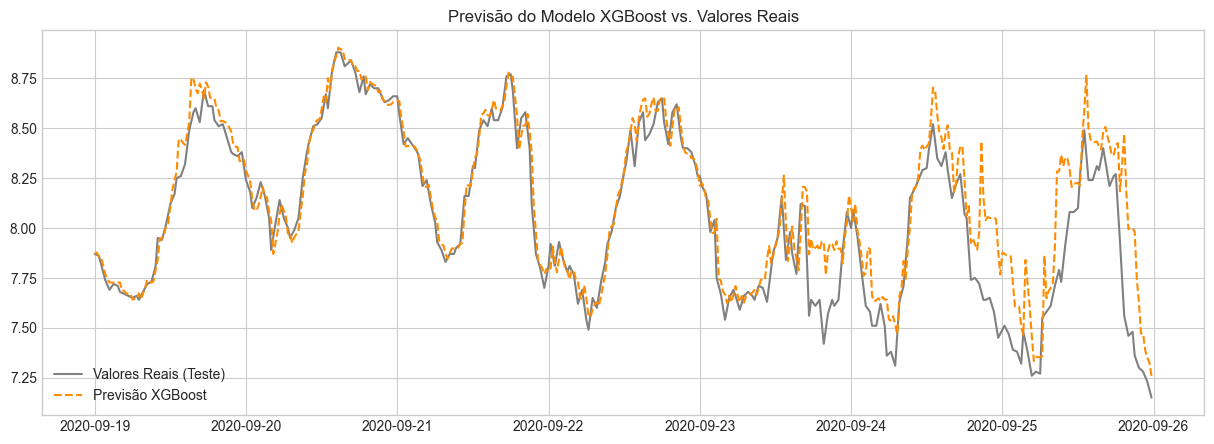

In [31]:
# --- Bibliotecas Adicionais ---
import xgboost as xgb
import time

# --- Assumimos que X_train, y_train, X_test, y_test já existem ---

# --- Treinamento do Modelo XGBoost ---
print("Iniciando o treinamento do modelo XGBoost...")
start_time = time.time()

# Inicializamos o modelo
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Objetivo padrão para regressão
    n_estimators=1000,
    learning_rate=0.05,
    n_jobs=-1,
    seed=42,
    early_stopping_rounds=100 # Equivalente ao early_stopping do LightGBM
)

# Treinar o modelo
# O XGBoost precisa que o eval_set seja passado dentro do .fit()
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False) # verbose=False para não imprimir o log de cada árvore

end_time = time.time()
print(f"Treinamento concluído em {end_time - start_time:.2f} segundos.")

# --- Previsão e Avaliação ---
xgb_forecast = xgb_model.predict(X_test)

# Calcular as métricas de erro
mae_xgb = mean_absolute_error(y_test, xgb_forecast)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_forecast))

print("\n--- Resultados do Modelo XGBoost ---")
print(f"MAE (Mean Absolute Error): {mae_xgb:.4f}")
print(f"RMSE (Root Mean Squared Error): {rmse_xgb:.4f}")

# --- Visualização ---
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray')
ax.plot(y_test.index, xgb_forecast, label='Previsão XGBoost', color='darkorange', linestyle='--')
ax.set_title('Previsão do Modelo XGBoost vs. Valores Reais')
ax.legend()
plt.show()

# Feature Engeneering test 3


In [42]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumimos que o DataFrame 'df' já foi carregado ---

# --- Sua Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features

# --- Listas de Parâmetros para o Grid Search ---
l_options = [
    [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72],
    [1, 2, 3, 4, 5, 6, 68, 69, 70, 71, 72],
    [1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]
]

l_windows_options = [
    [12, 24, 72],
    [6, 12, 72],
    [5, 12, 24]
]

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search Abrangente para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            # Lógica de treinamento específica para cada modelo
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else: # RandomForest e DecisionTree
                model.fit(X_train, y_train)
            
            # 4. Avaliar e Guardar Resultados
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Abrangente ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

--- Iniciando Grid Search Abrangente para Features e Modelos ---

[Iteração 1/9] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [12, 24, 72]
  -> Treinando LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7677
[LightGBM] [Info] Number of data points in the train set: 4536, number of used features: 36
[LightGBM] [Info] Start training from score 8.780000
     Resultado MAE (LightGBM): 0.0595
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.1093
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0632
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.1017

[Iteração 2/9] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [6, 12, 72]
  -> Treinando LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `for

,model,lags,windows,MAE
0,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[5, 12, 24]",0.053238
1,LightGBM,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[6, 12, 72]",0.053312
2,RandomForest,"[1, 2, 3, 4, 5, 6, 68, 69, 70, 71, 72]","[5, 12, 24]",0.054009
3,RandomForest,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[5, 12, 24]",0.055122
4,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[6, 12, 72]",0.055225
5,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[5, 12, 24]",0.055843
6,LightGBM,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[5, 12, 24]",0.057566
7,DecisionTree,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[5, 12, 24]",0.057769
8,LightGBM,"[1, 2, 3, 4, 5, 6, 68, 69, 70, 71, 72]","[6, 12, 72]",0.058244
9,RandomForest,"[1, 2, 3, 4, 5, 12, 24, 36, 48, 60, 72]","[6, 12, 72]",0.059169



--- Melhor Combinação Geral Encontrada ---


model                                      LightGBM
lags       [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]
windows                                 [5, 12, 24]
MAE                                        0.053238
Name: 0, dtype: object

In [43]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumimos que o DataFrame 'df' já foi carregado ---

# --- Sua Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features

# --- Novas Listas de Parâmetros para o Grid Search Fino ---
# Estas listas foram criadas com base nos resultados da primeira busca
# para explorar com mais detalhes as combinações de features mais promissoras.

l_options = [
    [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72],       # A Vencedora (Baseline Fino)
    [1, 2, 3, 4, 5, 6, 7, 8, 35, 36, 37, 71, 72, 73], # Variação da Ponte Sazonal
    [1, 2, 3, 6, 18, 24, 36, 72],                   # Lags Intermediários
    [1, 2, 3, 4, 5, 6, 7, 8, 36, 70, 71, 72, 73, 74], # Foco Sazonal Intenso
    [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 36, 72]   # Memória de Curto Prazo Estendida
]

l_windows_options = [
    [5, 12, 24],        # A Vencedora (Baseline Fino)
    [3, 6, 12],         # Foco em Tendências Super Curtas
    [6, 18, 36],        # Curto a Médio Prazo
    [4, 8, 16, 32],     # Granularidade Aumentada
    [6, 12, 36, 72]     # Combinação Mista Robusta
]

print("Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.")

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search Abrangente para Features e Modelos ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            # Lógica de treinamento específica para cada modelo
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else: # RandomForest e DecisionTree
                model.fit(X_train, y_train)
            
            # 4. Avaliar e Guardar Resultados
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search Abrangente ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

Novas listas de parâmetros 'l_options' e 'l_windows_options' definidas.
--- Iniciando Grid Search Abrangente para Features e Modelos ---

[Iteração 1/25] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [5, 12, 24]
  -> Treinando LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7677
[LightGBM] [Info] Number of data points in the train set: 4536, number of used features: 36
[LightGBM] [Info] Start training from score 8.780000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
     Resultado MAE (LightGBM): 0.0532
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0781
  -> Treinando RandomForest...
     Resultado MAE (RandomForest): 0.0558
  -> Treinando DecisionTree...
     Resultado MAE (DecisionTree): 0.0678

[Iteração 2/25] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [3, 6, 12]


,model,lags,windows,MAE
0,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 36, 72]","[3, 6, 12]",0.034207
1,RandomForest,"[1, 2, 3, 6, 18, 24, 36, 72]","[3, 6, 12]",0.034242
2,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 35, 36, 37, 71, 72, 73]","[3, 6, 12]",0.034644
3,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[3, 6, 12]",0.034830
4,LightGBM,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 36, 72]","[3, 6, 12]",0.035078
...,...,...,...,...
95,DecisionTree,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 70, 71, 72, 73, 74]","[6, 12, 36, 72]",0.113919
96,DecisionTree,"[1, 2, 3, 4, 5, 6, 7, 8, 35, 36, 37, 71, 72, 73]","[6, 12, 36, 72]",0.114774
97,DecisionTree,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 36, 72]","[6, 12, 36, 72]",0.127825
98,DecisionTree,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 70, 71, 72, 73, 74]","[6, 18, 36]",0.128352



--- Melhor Combinação Geral Encontrada ---


model                                         RandomForest
lags       [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 36, 72]
windows                                         [3, 6, 12]
MAE                                               0.034207
Name: 0, dtype: object

In [44]:
import pandas as pd
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import time

# --- Assumindo que o DataFrame 'df' já foi carregado ---

# --- Função de Engenharia de Features (sem alterações) ---
def create_features(df, target_variable='ph', lags_list=[1,2,3,72], window_sizes_list=[72]):
    df_features = df.copy()
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features

# --- Novas Listas de Parâmetros para o Grid Search Fino ---
l_options = [
    [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72],       # A Vencedora (Baseline Fino)
    list(range(1, 19)) + [36, 72],                   # Memória Densa Estendida (6h)
    [1, 2, 3, 6, 9, 12, 36, 72],                   # Menos é Mais? (Versão Esparsa)
    list(range(1, 13)) + [72],                      # Teste da Ponte Sazonal (Sem o lag 36)
    list(range(1, 9)) + [34, 35, 36, 37, 38, 72]    # Ponte Sazonal Reforçada
]

l_windows_options = [
    [3, 6, 12],         # A Campeã (Nosso Novo Benchmark)
    [2, 4, 8],          # Variação Ultra Curta
    [3, 6, 12, 18],     # Adicionando Média Duração
    [2, 3, 4, 5, 6],    # Máxima Granularidade Curta
    [5, 12, 24]         # A Vencedora da Primeira Busca (Controle)
]

# --- Dicionário de Modelos para Testar ---
models_to_test = {
    'LightGBM': lgb.LGBMRegressor(objective='mae', n_estimators=1000, learning_rate=0.05, num_leaves=31, n_jobs=-1, seed=42),
    'XGBoost': xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, n_jobs=-1, seed=42, early_stopping_rounds=100),
    'RandomForest': RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42),
    'DecisionTree': DecisionTreeRegressor(random_state=42)
}

# --- Rotina de Grid Search Abrangente ---
results_list = []
iteration_count = 0
total_iterations = len(l_options) * len(l_windows_options)

print("--- Iniciando Grid Search de Hiper-Refinamento (25 iterações) ---")
start_total_time = time.time()

for lags_combination in l_options:
    for windows_combination in l_windows_options:
        iteration_count += 1
        print(f"\n[Iteração {iteration_count}/{total_iterations}] Lags: {lags_combination} | Janelas: {windows_combination}")
        
        # 1. Criar Features
        df_featured = create_features(df, target_variable='ph', lags_list=lags_combination, window_sizes_list=windows_combination)
        df_featured = df_featured.dropna()
        
        # 2. Divisão Treino-Teste
        test_size = 7 * 24 * 3 
        train_featured = df_featured[:-test_size]
        test_featured = df_featured[-test_size:]
        
        FEATURES = [col for col in df_featured.columns if col != 'ph']
        TARGET = 'ph'
        X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
        X_test, y_test = test_featured[FEATURES], test_featured[TARGET]
        
        # 3. Loop para treinar e avaliar cada modelo
        for model_name, model in models_to_test.items():
            print(f"  -> Treinando {model_name}...")
            
            if model_name in ['LightGBM']:
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], eval_metric='mae', callbacks=[lgb.early_stopping(100, verbose=False)])
            elif model_name == 'XGBoost':
                model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
            else:
                model.fit(X_train, y_train)
            
            forecast = model.predict(X_test)
            mae = mean_absolute_error(y_test, forecast)
            
            results_list.append({
                'model': model_name,
                'lags': str(lags_combination),
                'windows': str(windows_combination),
                'MAE': mae
            })
            print(f"     Resultado MAE ({model_name}): {mae:.4f}")

end_total_time = time.time()
print(f"\n--- Grid Search Concluído em {end_total_time - start_total_time:.2f} segundos ---")

# --- Análise Final dos Resultados ---
grid_search_results_df = pd.DataFrame(results_list)
grid_search_results_df = grid_search_results_df.sort_values(by='MAE', ascending=True).reset_index(drop=True)

print("\n--- Tabela de Resultados do Grid Search de Hiper-Refinamento ---")
display(grid_search_results_df)

print("\n--- Melhor Combinação Geral Encontrada ---")
display(grid_search_results_df.iloc[0])

--- Iniciando Grid Search de Hiper-Refinamento (25 iterações) ---

[Iteração 1/25] Lags: [1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72] | Janelas: [3, 6, 12]
  -> Treinando LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7677
[LightGBM] [Info] Number of data points in the train set: 4536, number of used features: 36
[LightGBM] [Info] Start training from score 8.780000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
     Resultado MAE (LightGBM): 0.0358
  -> Treinando XGBoost...
     Resultado MAE (XGBoost): 0.0383
  ->

,model,lags,windows,MAE
0,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]","[2, 4, 8]",0.017937
1,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]","[2, 3, 4, 5, 6]",0.018043
2,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 72]","[2, 4, 8]",0.018317
3,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[2, 4, 8]",0.018329
4,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[2, 3, 4, 5, 6]",0.018482
...,...,...,...,...
95,XGBoost,"[1, 2, 3, 6, 9, 12, 36, 72]","[5, 12, 24]",0.079326
96,DecisionTree,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[5, 12, 24]",0.079332
97,XGBoost,"[1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]","[5, 12, 24]",0.079397
98,XGBoost,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 72]","[5, 12, 24]",0.083002



--- Melhor Combinação Geral Encontrada ---


model                                          RandomForest
lags       [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
windows                                           [2, 4, 8]
MAE                                                0.017937
Name: 0, dtype: object

In [47]:
display(grid_search_results_df.head(30))

,model,lags,windows,MAE
0,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]","[2, 4, 8]",0.017937
1,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]","[2, 3, 4, 5, 6]",0.018043
2,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 72]","[2, 4, 8]",0.018317
3,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[2, 4, 8]",0.018329
4,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 36, 37, 38, 72]","[2, 3, 4, 5, 6]",0.018482
5,RandomForest,"[1, 2, 3, 6, 9, 12, 36, 72]","[2, 3, 4, 5, 6]",0.018644
6,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 72]","[2, 3, 4, 5, 6]",0.018746
7,RandomForest,"[1, 2, 3, 6, 9, 12, 36, 72]","[2, 4, 8]",0.018757
8,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 3, 4, 5, 6]",0.018839
9,RandomForest,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[2, 4, 8]",0.018860


Retreinando o modelo campeão (RandomForest) com as melhores features...
Modelo treinado e previsões geradas.


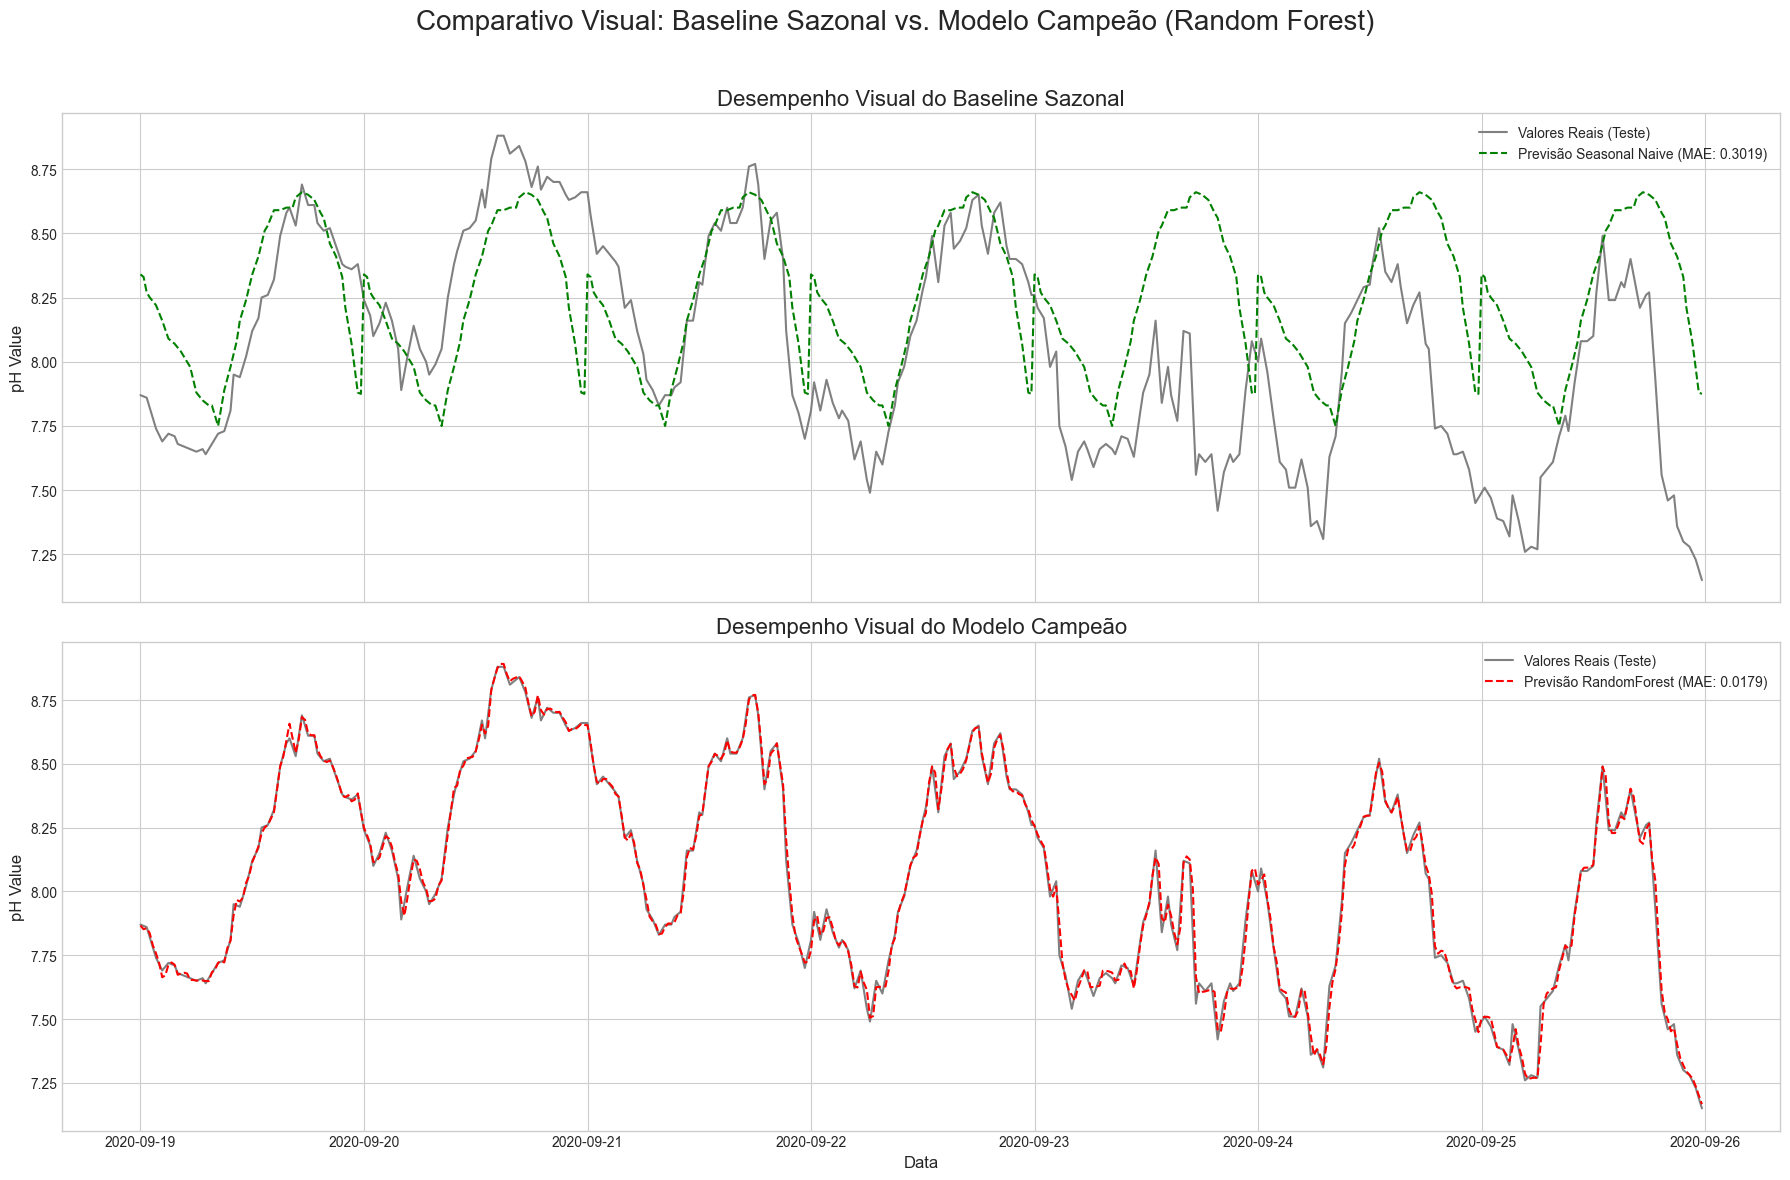

In [49]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pathlib import Path

# --- Assumimos que o DataFrame 'df' já foi carregado ---
# E que a função 'create_features' já foi definida em uma célula anterior

# --- 1. Recriar o Melhor Conjunto de Features Encontrado ---
best_lags = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
best_windows = [2, 4, 8]

df_champion_featured = create_features(df, target_variable='ph', lags_list=best_lags, window_sizes_list=best_windows)
df_champion_featured = df_champion_featured.dropna()

# --- 2. Divisão Treino-Teste ---
test_size = 7 * 24 * 3
train_featured = df_champion_featured[:-test_size]
test_featured = df_champion_featured[-test_size:]

FEATURES = [col for col in df_champion_featured.columns if col != 'ph']
TARGET = 'ph'
X_train, y_train = train_featured[FEATURES], train_featured[TARGET]
X_test, y_test = test_featured[FEATURES], test_featured[TARGET]

# --- 3. Retreinar o Modelo Campeão (Random Forest) ---
print("Retreinando o modelo campeão (RandomForest) com as melhores features...")
champion_model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
champion_model.fit(X_train, y_train)
champion_forecast = champion_model.predict(X_test)
print("Modelo treinado e previsões geradas.")

# --- 4. Gerar a Previsão do Seasonal Naive para Comparação ---
seasonal_period = 72
last_season_train = df['ph'][:-test_size][-seasonal_period:]

# CORREÇÃO APLICADA AQUI: Usando len(y_test) em vez de len(test_df)
num_replications = int(np.ceil(len(y_test) / seasonal_period))
seasonal_forecast_values = np.tile(last_season_train, num_replications)[:len(y_test)]
seasonal_naive_forecast = pd.Series(seasonal_forecast_values, index=y_test.index)

# --- 5. Criação dos Gráficos Comparativos ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 12), sharex=True)

# Gráfico 1: Seasonal Naive
ax1.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray', linewidth=1.5)
ax1.plot(y_test.index, seasonal_naive_forecast, label='Previsão Seasonal Naive (MAE: 0.3019)', color='green', linestyle='--')
ax1.set_title('Desempenho Visual do Baseline Sazonal', fontsize=16)
ax1.set_ylabel('pH Value', fontsize=12)
ax1.legend()

# Gráfico 2: Random Forest (Campeão)
ax2.plot(y_test.index, y_test, label='Valores Reais (Teste)', color='gray', linewidth=1.5)
ax2.plot(y_test.index, champion_forecast, label='Previsão RandomForest (MAE: 0.0179)', color='red', linestyle='--')
ax2.set_title('Desempenho Visual do Modelo Campeão', fontsize=16)
ax2.set_xlabel('Data', fontsize=12)
ax2.set_ylabel('pH Value', fontsize=12)
ax2.legend()

fig.suptitle('Comparativo Visual: Baseline Sazonal vs. Modelo Campeão (Random Forest)', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

# Best Lags, grid search hyperparams

In [53]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import time

# --- 1. Carregamento dos Dados ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (com a melhor combinação encontrada) ---
def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

# --- 3. Preparação dos Dados ---
df_featured = create_champion_features(df, target_variable='ph')

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- 4. Configuração do Grid Search ---
print("Configurando o Grid Search para o LightGBM...")

lgb_model = lgb.LGBMRegressor(objective='mae', n_estimators=1000, n_jobs=-1, verbose=-1, seed=42)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 20],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

tscv = TimeSeriesSplit(n_splits=5)

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2
)

# --- 5. Execução do Grid Search ---
print("Iniciando a busca pelos melhores hiperparâmetros... Isso pode demorar.")
start_time = time.time()

# #############################################################################
# CORREÇÃO APLICADA AQUI
# Adicionamos o 'eval_set' ao fit_params para que o callback saiba o que monitorar.
# #############################################################################
fit_params = {
    "eval_set": [(X_test, y_test)],
    "callbacks": [lgb.early_stopping(100, verbose=False)]
}

grid_search.fit(X_train, y_train, **fit_params)

end_time = time.time()
print(f"Grid Search concluído em {end_time - start_time:.2f} segundos.")

# --- 6. Análise dos Resultados ---
print("\n--- Melhores Hiperparâmetros Encontrados ---")
print(grid_search.best_params_)

best_score = -grid_search.best_score_
print(f"\nMelhor MAE na Validação Cruzada: {best_score:.4f}")

# --- 7. Avaliação Final no Conjunto de Teste (Holdout) ---
print("\nAvaliando o melhor modelo no conjunto de teste final...")
best_model = grid_search.best_estimator_
final_forecast = best_model.predict(X_test)
final_mae = mean_absolute_error(y_test, final_forecast)

print(f"\nMAE Final no Conjunto de Teste: {final_mae:.4f}")

Configurando o Grid Search para o LightGBM...
Iniciando a busca pelos melhores hiperparâmetros... Isso pode demorar.
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.01, max_depth=-1, num_leaves=20, reg_alpha=0, reg_lambda=0; total time=   2.2s
[CV] END learning_rate=0.01, max_depth=-1, num_leaves=20, reg_alpha=0, reg_lambda=0; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=-1, num_leaves=20, reg_alpha=0, reg_lambda=0; total time=   3.0s
[CV] END learning_rate=0.01, max_depth=-1, num_leaves=20, reg_alpha=0, reg_lambda=0; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=-1, num_leaves=20, reg_alpha=0, reg_lambda=0; total time=   3.2s
[CV] END learning_rate=0.01, max_depth=-1, num_leaves=20, reg_alpha=0, reg_lambda=0.1; total time=   2.0s
[CV] END learning_rate=0.01, max_depth=-1, num_leaves=20, reg_alpha=0, reg_lambda=0.1; total time=   2.6s
[CV] END learning_rate=0.01, max_depth=-1, num_leaves=20, reg_alpha=0, reg_lambda=0.1; 

# Grid Search XGBoost


In [56]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import time

# --- 1. Carregamento dos Dados ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (com a melhor combinação encontrada) ---
def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

# --- 3. Preparação dos Dados ---
df_featured = create_champion_features(df, target_variable='ph')

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- 4. Configuração do Grid Search para XGBoost ---
print("Configurando o Grid Search para o XGBoost...")

# Modelo base com early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    n_jobs=-1,
    seed=42,
    early_stopping_rounds=100
)

# Grade de hiperparâmetros que vamos testar
param_grid_xgb = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Validação Cruzada específica para Séries Temporais
tscv = TimeSeriesSplit(n_splits=5)

# Objeto do Grid Search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2
)

# --- 5. Execução do Grid Search ---
print("Iniciando a busca pelos melhores hiperparâmetros para o XGBoost... Isso pode demorar.")
start_time = time.time()

# O XGBoost precisa que o eval_set seja passado dentro do .fit() para o early stopping
# O GridSearchCV lida com isso automaticamente ao passar os dados
grid_search_xgb.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

end_time = time.time()
print(f"Grid Search concluído em {end_time - start_time:.2f} segundos.")

# --- 6. Análise dos Resultados ---
print("\n--- Melhores Hiperparâmetros Encontrados para o XGBoost ---")
print(grid_search_xgb.best_params_)

best_score_xgb = -grid_search_xgb.best_score_
print(f"\nMelhor MAE na Validação Cruzada: {best_score_xgb:.4f}")

# --- 7. Avaliação Final no Conjunto de Teste (Holdout) ---
print("\nAvaliando o melhor modelo XGBoost no conjunto de teste final...")
best_model_xgb = grid_search_xgb.best_estimator_
final_forecast_xgb = best_model_xgb.predict(X_test)
final_mae_xgb = mean_absolute_error(y_test, final_forecast_xgb)

print(f"\nMAE Final no Conjunto de Teste (XGBoost Otimizado): {final_mae_xgb:.4f}")

Configurando o Grid Search para o XGBoost...
Iniciando a busca pelos melhores hiperparâmetros para o XGBoost... Isso pode demorar.
Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, subsample=0.7; total time=   1.0s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, subsample=0.7; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, subsample=1.0; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, subsample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.05, max_depth=3, subsample=1.0; total time=   0.3s
[CV] END colsample_bytr

# Grid search DEcision Tree

In [57]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import time

# --- 1. Carregamento dos Dados ---
caminho_saida_parquet = r'D:\DOUTORADO\DOUTORADO_NOTEBOOK_JPY/df_DocFinal2025.parquet'
df = pd.read_parquet(caminho_saida_parquet)

# --- 2. Função de Engenharia de Features (com a melhor combinação encontrada) ---
def create_champion_features(df, target_variable='ph'):
    df_features = df.copy()
    lags_list = [1, 2, 3, 4, 5, 6, 7, 8, 34, 35, 36, 37, 38, 72]
    window_sizes_list = [2, 4, 8]
    
    for lag in lags_list:
        df_features[f'{target_variable}_lag_{lag}'] = df_features[target_variable].shift(lag)
    for window in window_sizes_list:
        df_features[f'{target_variable}_rolling_mean_{window}'] = df_features[target_variable].rolling(window=window).mean()
        df_features[f'{target_variable}_rolling_std_{window}'] = df_features[target_variable].rolling(window=window).std()
    return df_features.dropna()

# --- 3. Preparação dos Dados ---
df_featured = create_champion_features(df, target_variable='ph')

FEATURES = [col for col in df_featured.columns if col != 'ph']
TARGET = 'ph'
X = df_featured[FEATURES]
y = df_featured[TARGET]

train_size = len(df_featured) - (7 * 24 * 3)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# --- 4. Configuração do Grid Search para Decision Tree ---
print("Configurando o Grid Search para a Decision Tree...")

# Modelo base
dt_model = DecisionTreeRegressor(random_state=42)

# Grade de hiperparâmetros que vamos testar
param_grid_dt = {
    'max_depth': [10, 20, None], # None significa sem limite
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'criterion': ['squared_error', 'absolute_error']
}

# Validação Cruzada específica para Séries Temporais
tscv = TimeSeriesSplit(n_splits=5)

# Objeto do Grid Search
grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2
)

# --- 5. Execução do Grid Search ---
print("Iniciando a busca pelos melhores hiperparâmetros para a Decision Tree... Isso pode demorar.")
start_time = time.time()

grid_search_dt.fit(X_train, y_train)

end_time = time.time()
print(f"Grid Search concluído em {end_time - start_time:.2f} segundos.")

# --- 6. Análise dos Resultados ---
print("\n--- Melhores Hiperparâmetros Encontrados para a Decision Tree ---")
print(grid_search_dt.best_params_)

best_score_dt = -grid_search_dt.best_score_
print(f"\nMelhor MAE na Validação Cruzada: {best_score_dt:.4f}")

# --- 7. Avaliação Final no Conjunto de Teste (Holdout) ---
print("\nAvaliando a melhor Decision Tree no conjunto de teste final...")
best_model_dt = grid_search_dt.best_estimator_
final_forecast_dt = best_model_dt.predict(X_test)
final_mae_dt = mean_absolute_error(y_test, final_forecast_dt)

print(f"\nMAE Final no Conjunto de Teste (Decision Tree Otimizada): {final_mae_dt:.4f}")

Configurando o Grid Search para a Decision Tree...
Iniciando a busca pelos melhores hiperparâmetros para a Decision Tree... Isso pode demorar.
Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=2; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max_depth=10, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END criterion=squared_error, max